In [32]:
import glob
import os
import pandas as pd
import numpy as np
import gc
# import pandas_profiling as pdp
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
# 指定したファイルパスのcsvファイルを全部読み込む関数
def read_csv_all(target_path = '../input/'):
    for file in glob.glob(target_path+'*.csv'):
        raw_name = 'raw_' + file.replace(target_path,'').replace('.csv','')
        exec('{} = pd.read_csv(\'{}\')'.format(raw_name, file), globals())
        print('read {} as {}'.format(file, raw_name))

In [3]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [4]:
read_csv_all()

read ../input/calendar.csv as raw_calendar
read ../input/sell_prices.csv as raw_sell_prices
read ../input/sales_train_validation.csv as raw_sales_train_validation
read ../input/sample_submission.csv as raw_sample_submission


In [10]:
NUM_ITEMS = raw_sales_train_validation.shape[0]  # 30490
DAYS_PRED = raw_sample_submission.shape[1] - 1  # 28

In [11]:
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df

In [12]:
calendar = encode_categorical(
    raw_calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales = encode_categorical(
    raw_sales_train_validation, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

prices = encode_categorical(raw_sell_prices, ["item_id", "store_id"]).pipe(reduce_mem_usage)

In [13]:
submission = raw_sample_submission

In [14]:
def extract_num(ser):
    return ser.str.extract(r"(\d+)").astype(np.int16)

def reshape_sales(sales, submission, d_thresh=0, verbose=True):
    # melt sales data, get it ready for training
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

    # get product table.
    product = sales[id_columns]

    sales = sales.melt(id_vars=id_columns, var_name="d", value_name="demand",)
    sales = reduce_mem_usage(sales)

    # separate test dataframes.
    vals = submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    # change column names.
    vals.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    # merge with product table
    evals["id"] = evals["id"].str.replace("_evaluation", "_validation")
    vals = vals.merge(product, how="left", on="id")
    evals = evals.merge(product, how="left", on="id")
    evals["id"] = evals["id"].str.replace("_validation", "_evaluation")

    if verbose:
        print("validation")
        display(vals)

        print("evaluation")
        display(evals)

    vals = vals.melt(id_vars=id_columns, var_name="d", value_name="demand")
    evals = evals.melt(id_vars=id_columns, var_name="d", value_name="demand")

    sales["part"] = "train"
    vals["part"] = "validation"
    evals["part"] = "evaluation"

    data = pd.concat([sales, vals, evals], axis=0)

    del sales, vals, evals

    data["d"] = extract_num(data["d"])
    data = data[data["d"] >= d_thresh]

    # delete evaluation for now.
    data = data[data["part"] != "evaluation"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data


def merge_calendar(data, calendar):
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)
    return data.merge(calendar, how="left", on="d")


def merge_prices(data, prices):
    return data.merge(prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

In [16]:
data = reshape_sales(sales, submission, d_thresh=1941 - int(365 * 2))
del sales
gc.collect()

calendar["d"] = extract_num(calendar["d"])
data = merge_calendar(data, calendar)
del calendar
gc.collect()

data = merge_prices(data, prices)
del prices
gc.collect()

data = reduce_mem_usage(data)

validation


/Users/hojokenta/.local/share/virtualenvs/M5_Forecasting_Accuracy-hifQUVP_/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,...,d_1937,d_1938,d_1939,d_1940,d_1941,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1441,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1432,2,0,9,2
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1433,2,0,9,2
30487,FOODS_3_825_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1434,2,0,9,2
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1435,2,0,9,2


evaluation


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,...,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1441,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1432,2,0,9,2
30486,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1433,2,0,9,2
30487,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1434,2,0,9,2
30488,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1435,2,0,9,2


data


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part
36892900,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1211,1,train
36892901,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1211,0,train
36892902,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1211,0,train
36892903,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1211,1,train
36892904,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1211,2,train
...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_validation,1432,2,0,9,2,1941,0,validation
853716,FOODS_3_824_WI_3_validation,1433,2,0,9,2,1941,0,validation
853717,FOODS_3_825_WI_3_validation,1434,2,0,9,2,1941,0,validation
853718,FOODS_3_826_WI_3_validation,1435,2,0,9,2,1941,0,validation


In [17]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1211,1,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,8.26
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,3.97
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,2.97
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1211,1,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,4.64
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1211,2,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,3.08


In [18]:
def add_demand_features(df):
    for diff in [0, 1, 2]:
        shift = DAYS_PRED + diff
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(shift)
        )

    for window in [7, 30, 60, 90, 180]:
        df[f"rolling_std_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).std()
        )

    for window in [7, 30, 60, 90, 180]:
        df[f"rolling_mean_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).mean()
        )

    for window in [7, 30, 60]:
        df[f"rolling_min_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).min()
        )

    for window in [7, 30, 60]:
        df[f"rolling_max_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).max()
        )

    df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).skew()
    )
    df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).kurt()
    )
    return df


def add_price_features(df):
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        df["rolling_price_max_t365"]
    )

    df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(7).std()
    )
    df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(30).std()
    )
    return df.drop(["rolling_price_max_t365", "shift_price_t1"], axis=1)


def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "year",
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    return df

In [19]:
data = add_demand_features(data).pipe(reduce_mem_usage)
data = add_price_features(data).pipe(reduce_mem_usage)
dt_col = "date"
data = add_time_features(data, dt_col).pipe(reduce_mem_usage)
data = data.sort_values("date")

print("start date:", data[dt_col].min())
print("end date:", data[dt_col].max())
print("data shape:", data.shape)

start date: 2014-05-23 00:00:00
end date: 2016-05-22 00:00:00
data shape: (22288190, 51)


In [20]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,...,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,year,quarter,month,week,day,dayofweek,is_weekend
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1211,1,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,21,23,4,0
20334,FOODS_2_214_TX_3_validation,428,1,0,6,1,1211,0,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,21,23,4,0
20333,FOODS_2_213_TX_3_validation,427,1,0,6,1,1211,0,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,21,23,4,0
20332,FOODS_2_212_TX_3_validation,426,1,0,6,1,1211,0,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,21,23,4,0
20331,FOODS_2_211_TX_3_validation,425,1,0,6,1,1211,0,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,21,23,4,0


In [21]:
display(data.columns)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'demand', 'part', 'date', 'wm_yr_wk', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
       'sell_price', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7',
       'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90',
       'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30',
       'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180',
       'rolling_min_t7', 'rolling_min_t30', 'rolling_min_t60',
       'rolling_max_t7', 'rolling_max_t30', 'rolling_max_t60',
       'rolling_skew_t30', 'rolling_kurt_t30', 'price_change_t1',
       'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30',
       'year', 'quarter', 'month', 'week', 'day', 'dayofweek', 'is_weekend'],
      dtype='object')

In [23]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 3600 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            # step = (duration - total_sec) / (self.n_splits - 1)
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                # train_start = idx * step
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

In [24]:
day_col = "d"
cv_params = {
    "n_splits": 3,
    "train_days": int(365 * 1.5),
    "test_days": DAYS_PRED,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

In [25]:
def show_cv_days(cv, X, dt_col, day_col):
    for ii, (tr, tt) in enumerate(cv.split(X)):
        print(f"----- Fold: ({ii + 1} / {cv.n_splits}) -----")
        tr_start = X.iloc[tr][dt_col].min()
        tr_end = X.iloc[tr][dt_col].max()
        tr_days = X.iloc[tr][day_col].max() - X.iloc[tr][day_col].min() + 1

        tt_start = X.iloc[tt][dt_col].min()
        tt_end = X.iloc[tt][dt_col].max()
        tt_days = X.iloc[tt][day_col].max() - X.iloc[tt][day_col].min() + 1

        df = pd.DataFrame(
            {
                "start": [tr_start, tt_start],
                "end": [tr_end, tt_end],
                "days": [tr_days, tt_days],
            },
            index=["train", "test"],
        )

        display(df)


def plot_cv_indices(cv, X, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

----- Fold: (1 / 3) -----


,start,end,days
train,2014-08-31,2016-02-28,547
test,2016-02-29,2016-03-27,28


----- Fold: (2 / 3) -----


,start,end,days
train,2014-09-28,2016-03-27,547
test,2016-03-28,2016-04-24,28


----- Fold: (3 / 3) -----


,start,end,days
train,2014-10-26,2016-04-24,547
test,2016-04-25,2016-05-22,28


/Users/hojokenta/.local/share/virtualenvs/M5_Forecasting_Accuracy-hifQUVP_/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


34

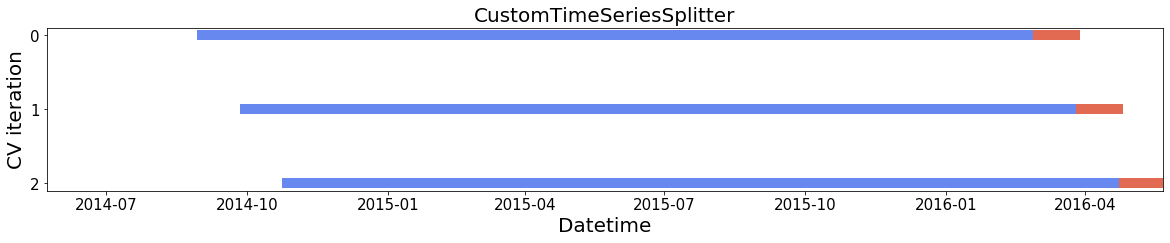

In [28]:
sample = data.iloc[::1000][[day_col, dt_col]].reset_index(drop=True)
show_cv_days(cv, sample, dt_col, day_col)
plot_cv_indices(cv, sample, dt_col)

del sample
gc.collect()

In [29]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features
    "shift_t28",
    "shift_t29",
    "shift_t30",
    # std
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    # mean
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    # min
    "rolling_min_t7",
    "rolling_min_t30",
    "rolling_min_t60",
    # max
    "rolling_max_t7",
    "rolling_max_t30",
    "rolling_max_t60",
    # others
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features
    "year",
    "quarter",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
]

# prepare training and test data.
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

is_train = data["d"] < 1914

# Attach "d" to X_train for cross validation.
X_train = data[is_train][[day_col] + features].reset_index(drop=True)
y_train = data[is_train]["demand"].reset_index(drop=True)
X_test = data[~is_train][features].reset_index(drop=True)

# keep these two columns to use later.
id_date = data[~is_train][["id", "date"]].reset_index(drop=True)

del data
gc.collect()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (21434470, 46)
X_test shape: (853720, 45)


In [30]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(
            X_trn.drop(drop_when_train, axis=1),
            label=y_trn,
            categorical_feature=["item_id"],
        )
        val_set = lgb.Dataset(
            X_val.drop(drop_when_train, axis=1),
            label=y_val,
            categorical_feature=["item_id"],
        )

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [33]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.1,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=[day_col]
)

del X_train, y_train
gc.collect()


----- Fold: (1 / 3) -----



/Users/hojokenta/.local/share/virtualenvs/M5_Forecasting_Accuracy-hifQUVP_/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's rmse: 2.21109	valid's rmse: 2.34129

----- Fold: (2 / 3) -----

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.14237	valid's rmse: 2.30667
Early stopping, best iteration is:
[69]	train's rmse: 2.17087	valid's rmse: 2.29385

----- Fold: (3 / 3) -----

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.14599	valid's rmse: 2.12116
Early stopping, best iteration is:
[117]	train's rmse: 2.13546	valid's rmse: 2.11656


0

In [34]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [35]:
imp_type = "gain"
importances = np.zeros(X_test.shape[1])
preds = np.zeros(X_test.shape[0])

for model in models:
    preds += model.predict(X_test)
    importances += model.feature_importance(imp_type)

preds = preds / cv.get_n_splits()
importances = importances / cv.get_n_splits()

In [43]:
preds

array([1.21185962, 0.18368068, 0.44685767, ..., 0.32275606, 0.22312255,
       1.24899067])

In [44]:
cv.get_n_splits()

3

In [36]:
def make_submission(test, submission):
    preds = test[["id", "date", "demand"]]
    preds = preds.pivot(index="id", columns="date", values="demand").reset_index()
    preds.columns = ["id"] + ["F" + str(d + 1) for d in range(DAYS_PRED)]

    vals = submission[["id"]].merge(preds, how="inner", on="id")
    evals = submission[submission["id"].str.endswith("evaluation")]
    final = pd.concat([vals, evals])

    assert final.drop("id", axis=1).isnull().sum().sum() == 0
    assert final["id"].equals(submission["id"])

    final.to_csv("../output/submission_baseline.csv", index=False)

In [37]:
make_submission(id_date.assign(demand=preds), submission)

In [45]:
id_date.assign(demand=preds)

,id,date,demand
0,FOODS_2_208_TX_3_validation,2016-04-25,1.211860
1,FOODS_2_205_TX_3_validation,2016-04-25,0.183681
2,FOODS_2_206_TX_3_validation,2016-04-25,0.446858
3,FOODS_2_207_TX_3_validation,2016-04-25,0.150686
4,FOODS_2_209_TX_3_validation,2016-04-25,0.924425
...,...,...,...
853715,HOUSEHOLD_1_454_CA_4_validation,2016-05-22,0.313546
853716,HOUSEHOLD_1_453_CA_4_validation,2016-05-22,1.721148
853717,HOUSEHOLD_1_452_CA_4_validation,2016-05-22,0.322756
853718,HOUSEHOLD_1_464_CA_4_validation,2016-05-22,0.223123


In [41]:
test = pd.read_csv('../output/submission_baseline.csv')
test.tail()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,FOODS_3_823_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60976,FOODS_3_824_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60977,FOODS_3_825_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60978,FOODS_3_826_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60979,FOODS_3_827_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
